# Interactions

## Introduction

In this section, you'll learn about interactions and how to account for them in regression models.

## Objectives

You will be able to:
- Understand what interactions are
- Understand how to accommodate for interactions in regression

## What are interactions?

In statistics, an interaction is a particular property of three or more variables, where two or more variables *interact in a non-additive manner* when affecting a third variable. In other words, the two variables interact to have an effect that is more (or less) than the sum of their parts. 

This might seem pretty abstract, let's use an example to illustrate this.

Let's assume we're trying to predict weight loss of certain people who took a diet, given two (categorical) predictors: the country, and the type of diet they followed. Have a look at the plot below.

- Considering just the people in the USA and the UK, it seems like the effects of both predictors are additive:
    * Weight loss is bigger in the UK than in the USA.
    * Diet C is more effective than diet A. Diet A is more effective than diet B, which makes diet B the least effective.
- When you look at New Zealand, however, it seems like the average weight loss is somewhere between the weight loss for USA and UK, but people seem to be responding much better to diet C than in the other contries. 

<img src='diet_image.png' style="width: 500px;">

This means that the "Country" and "Diet" affect the weight loss in a non-additive matter. If we're mostly interested in the effect of diet on weight loss (which seems to be plausible here), we say that Country is a **confounding factor** of the effect of "Diet" on weight loss.

## Why is it important to account for interactions?

Now that you've seen how interactions work, let's now discuss why it is important to add interaction terms. The reason for that is pretty straightforward: not accounting for them might lead to results that are wrong. You'll also notice that including them when they're needed will increase your $R^2$ value!

In our example the interaction plot was composed out of categorical predictors (countries and diet type), but interactions can occur between categorical variables or between a mix of categorical variables and continuous variables!

Let's go back to our "cars" data set and look at some interactions we can include there.

In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from itertools import combinations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv("auto-mpg.csv") 
y = data[["mpg"]]
X = data.drop(["mpg", "car name"], axis=1)

In [2]:
import pandas as pd
import numpy as np
data = pd.read_csv("auto-mpg.csv") 
data['horsepower'].astype(str).astype(int)

acc = data["acceleration"]
logdisp = np.log(data["displacement"])
loghorse = np.log(data["horsepower"])
logweight= np.log(data["weight"])

scaled_acc = (acc-min(acc))/(max(acc)-min(acc))	
scaled_disp = (logdisp-np.mean(logdisp))/np.sqrt(np.var(logdisp))
scaled_horse = (loghorse-np.mean(loghorse))/(max(loghorse)-min(loghorse))
scaled_weight= (logweight-np.mean(logweight))/np.sqrt(np.var(logweight))

data_fin = pd.DataFrame([])
data_fin["acc"]= scaled_acc
data_fin["disp"]= scaled_disp
data_fin["horse"] = scaled_horse
data_fin["weight"] = scaled_weight
mpg = data["mpg"]
data_fin = pd.concat([mpg, data_fin, data["cylinders"], data["model year"], data["origin"]], axis=1)
y = data_fin[["mpg"]]
X = data_fin.drop(["mpg"], axis=1)

In [3]:
regression = LinearRegression()
crossvalidation = KFold(n_splits=3, shuffle=True, random_state=1)

baseline = np.mean(cross_val_score(regression, X, y, scoring="r2", cv=crossvalidation))
baseline

0.8322880898272431

See how we built a baseline model using some (log-transformed etc) predictors and some categorical predictors. We didn't properly convert the categorical variables to categorical yet, which we should do in the end, but we want to start with a baseline model and a baseline $R^2$ just to get a sense of what a baseline model looks like.

## Interactions between horsepower and origin

To look at how horsepower and origin interact, we can work as follows. We split our data in 3 data sets, one set per origin. Then we fit a model with outcome "mpg" and only horsepower as a predictor, and do this for each of the data set. Then we plot the data all together and see what our regression lines look like.

In [4]:
origin_1 = data_fin[data_fin["origin"]==1]
origin_2 = data_fin[data_fin["origin"]==2]
origin_3 = data_fin[data_fin["origin"]==3]
origin_1.head()

,mpg,acc,disp,horse,weight,cylinders,model year,origin
0,18.0,0.238095,1.125829,0.173727,0.720986,8,70,1
1,15.0,0.208333,1.372223,0.321860,0.908047,8,70,1
2,18.0,0.178571,1.191999,0.262641,0.651205,8,70,1
3,16.0,0.238095,1.107370,0.262641,0.648095,8,70,1
4,17.0,0.148810,1.094964,0.219773,0.664652,8,70,1


In [5]:
regression_1 = LinearRegression()
regression_2 = LinearRegression()
regression_3 = LinearRegression()

horse_1 = origin_1["horse"].values.reshape(-1, 1)
horse_2 = origin_2["horse"].values.reshape(-1, 1)
horse_3 = origin_3["horse"].values.reshape(-1, 1)

regression_1.fit(horse_1, origin_1["mpg"])
regression_2.fit(horse_2, origin_2["mpg"])
regression_3.fit(horse_3, origin_3["mpg"])

# Make predictions using the testing set
pred_1 = regression_1.predict(horse_1)
pred_2 = regression_2.predict(horse_2)
pred_3 = regression_3.predict(horse_3)

# The coefficients
print(regression_1.coef_)
print(regression_2.coef_)
print(regression_3.coef_)

[-25.29729196]
[-28.17074549]
[-30.73684923]


You can see that we have three different estimates for the slope,  -25.29 for origin = 1, -28.17 for origin = 2, and -30.74 for origin = 3. It is not unexpected to see that they are slightly different. Now, let's look at the plot.

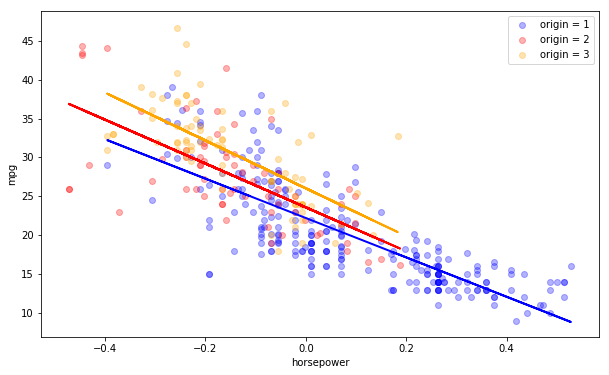

In [6]:
# Plot outputs
plt.figure(figsize=(10,6))

plt.scatter(horse_1, origin_1["mpg"],  color='blue', alpha = 0.3, label = "origin = 1")
plt.scatter(horse_2, origin_2["mpg"],  color='red', alpha = 0.3, label = "origin = 2")
plt.scatter(horse_3, origin_3["mpg"],  color='orange', alpha = 0.3, label = "origin = 3")

plt.plot(horse_1, pred_1,  color='blue', linewidth=2)
plt.plot(horse_2, pred_2,  color='red', linewidth=2)
plt.plot(horse_3, pred_3,  color='orange', linewidth=2)
plt.ylabel("mpg")
plt.xlabel("horsepower")
plt.legend();

Even though we get three different lines at different levels, they do seem to be more or less parallel, so the effect seems pretty additive. Just based on looking at this, it seems like there is no real interaction and the effect of origin when predicting mpg using horsepower is additive. It might not be necessary to include an interaction effect in our model. But how would actually include interaction effects in our model? To do this, you basically multiply 2 predictors. Let's add an interaction effect between origin and horsepower and see how it affects or $R^2$. 

In [7]:
regression = LinearRegression()
crossvalidation = KFold(n_splits=3, shuffle=True, random_state=1)

X_interact = X.copy()
X_interact["horse_origin"] = X["horse"] * X["origin"]

interact_horse_origin = np.mean(cross_val_score(regression, X_interact, y, scoring="r2", cv=crossvalidation))
interact_horse_origin

0.8416810370430339

By actually including an interaction effect here, we did bump our $R^2$ to 0.841 from 0.832, so about 1%! Let's now run the same model in statsmodels to see if the interaction effect is significant.

In [8]:
import statsmodels.api as sm
X_interact = sm.add_constant(X_interact)
model = sm.OLS(y,X_interact)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     285.6
Date:                Fri, 07 Dec 2018   Prob (F-statistic):          2.84e-156
Time:                        13:55:30   Log-Likelihood:                -980.75
No. Observations:                 392   AIC:                             1980.
Df Residuals:                     383   BIC:                             2015.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -30.5230      4.092     -7.460      0.000     -38.568     -22.478
acc             -3.8734      1.680     -2.306      0.022      -7.177      -0.570
disp            -1.0423      0.738     -1.412      0.159      -2.494       0.409
horse            1.6583      3.342      0.496      0.620      -4.912       8.228
weight          -3.3236      0.610     -5.452      0.000      -4.522      -2.125
cylinders       -0.0596      0.296     -0.201      0.841      -0.642       0.523
model year       0.7318      0.046     16.002      0.000       0.642       0.822
origin          -0.0913      0.331     -0.276      0.783      -0.743       0.560
horse_origin    -6.9316      1.446     -4.793      0.000      -9.775      -4.088
==============================================================================
Omnibus:                       51.231   Durbin-Watson:                   1.542
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              102.044
Skew:                           0.725   Prob(JB):                     6.94e-23
Kurtosis:                       5.036   Cond. No.                     2.13e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.13e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Even though the lines look parallel, the interaction effect between horsepower and origin is significant and the R^2 value increased to 0.841.

## Interactions between horsepower and model year

How about interactions between two continuous variables? Let's explore interactions between horsepower and model year. We're interested to see if the effect of horsepower on mpg if different between older cars and younger cars. 

In [9]:
yr_old = data_fin[:180] # cars from 70 to 75
yr_young = data_fin[180:] # cars from 76 to 82

What we did here is split the data up to create two data sets, for "older" cars and "younger" cars.

In [10]:
plt.figure(figsize=(12,7))

regression_1 = LinearRegression()
regression_2 = LinearRegression()

horse_1 = yr_old["horse"].values.reshape(-1, 1)
horse_2 = yr_young["horse"].values.reshape(-1, 1)

regression_1.fit(horse_1, yr_old["mpg"])
regression_2.fit(horse_2, yr_young["mpg"])

# Make predictions using the testing set
pred_1 = regression_1.predict(horse_1)
pred_2 = regression_2.predict(horse_2)

# The coefficients
print(regression_1.coef_)
print(regression_2.coef_)

[-21.39522143]
[-35.10169206]


<Figure size 864x504 with 0 Axes>

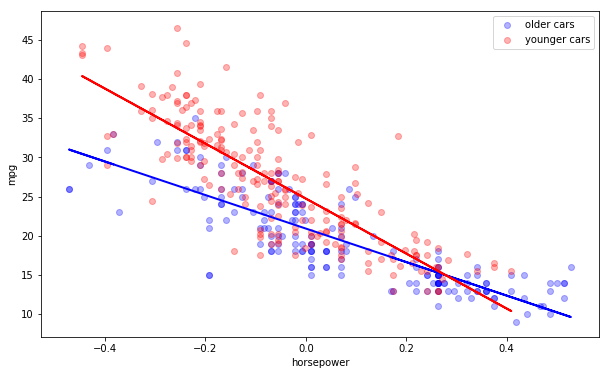

In [11]:
# Plot outputs
plt.figure(figsize=(10,6))

plt.scatter(horse_1, yr_old["mpg"],  color='blue', alpha = 0.3, label = "older cars")
plt.scatter(horse_2, yr_young["mpg"],  color='red', alpha = 0.3, label = "younger cars")

plt.plot(horse_1, pred_1,  color='blue', linewidth=2)
plt.plot(horse_2, pred_2,  color='red', linewidth=2)

plt.ylabel("mpg")
plt.xlabel("horsepower")
plt.legend();

More than for our previous example. there seems to be an interaction between horsepower and cars. Let's add the interaction effect in our model and see how it affects $R^2$. 

In [12]:
regression = LinearRegression()
crossvalidation = KFold(n_splits=3, shuffle=True, random_state=1)

X_interact_2 = X.copy()
X_interact_2["horse_year"] = X["horse"] * X["model year"]

interact_horse_origin = np.mean(cross_val_score(regression, X_interact_2, y, scoring="r2", cv=crossvalidation))
interact_horse_origin

0.8597777940161041

This result confirms what we have seen before: including this interaction has an even bigger effect on the $R^2$. When running this in statsmodels, unsurprisingly, the effect is significant.

In [13]:
import statsmodels.api as sm
X_interact_2 = sm.add_constant(X_interact_2)
model = sm.OLS(y,X_interact_2)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     331.7
Date:                Fri, 07 Dec 2018   Prob (F-statistic):          5.05e-167
Time:                        13:56:29   Log-Likelihood:                -955.36
No. Observations:                 392   AIC:                             1929.
Df Residuals:                     383   BIC:                             1964.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -30.3764      3.792     -8.010      0.000     -37.832     -22.920
acc           -2.2225      1.575     -1.411      0.159      -5.319       0.874
disp          -0.9066      0.689     -1.315      0.189      -2.262       0.449
horse        120.4052     14.754      8.161      0.000      91.395     149.415
weight        -3.7671      0.561     -6.712      0.000      -4.871      -2.664
cylinders      0.3899      0.260      1.498      0.135      -0.122       0.902
model year     0.6736      0.043     15.550      0.000       0.588       0.759
origin         0.6130      0.256      2.396      0.017       0.110       1.116
horse_year    -1.7272      0.194     -8.896      0.000      -2.109      -1.345
==============================================================================
Omnibus:                       32.600   Durbin-Watson:                   1.580
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               67.171
Skew:                           0.465   Prob(JB):                     2.59e-15
Kurtosis:                       4.802   Cond. No.                     7.96e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.96e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Additional resources

- You can use the Python library seaborn plots to visualize interactions as well. Have a look [here](https://blog.insightdatascience.com/data-visualization-in-python-advanced-functionality-in-seaborn-20d217f1a9a6) for more information.

- [This resource](https://cran.r-project.org/web/packages/jtools/vignettes/interactions.html) walks over a few datasets with interactions. Even though the code is in R, it might give you some additional insights in how interactions work.


## Summary

Great! You now know how to interpret interactions, how to include them in your model and how to interpret them. Obviously, nothing stops you from adding multiple interactions at the same time, and you probably should in many occasions. You'll practice what you learned in the next lab, including interactions 